In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import os
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

In [17]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def is_valid_image(file_path):
    """Check if a file is a valid image."""
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except Exception:
        return False


def filter_valid_images(file_paths):
    """Filter valid images using multiprocessing."""
    with Pool(cpu_count()) as pool:
        results = pool.map(is_valid_image, file_paths)
    return [file_path for file_path, is_valid in zip(file_paths, results) if is_valid]

In [18]:
def load_dataset(data_path, batch_size=64, num_workers=4):

    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(root=data_path, transform=train_transforms)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    val_dataset.dataset.transform = val_transforms

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

In [19]:
def visualize_images(dataloader, class_names, num_images=5):
    images, labels = next(iter(dataloader))
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

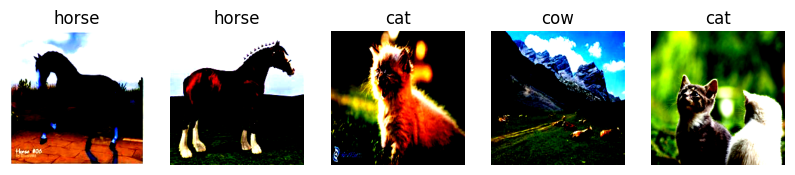

In [20]:
data_path = "/content/drive/My Drive/raw-img"
train_loader, val_loader = load_dataset(data_path)

class_names = train_loader.dataset.dataset.classes

visualize_images(train_loader, class_names)

In [21]:
transfer_model = resnet18(weights=ResNet18_Weights.DEFAULT)

transfer_model.fc = nn.Linear(transfer_model.fc.in_features, len(class_names))

transfer_model = transfer_model.to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
best_val_loss = float('inf')
patience = 5
no_improvement = 0

def train(model, train_loader, val_loader, criterion, optimizer, epochs=15):
    global best_val_loss, no_improvement
    model.train()
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        with tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', ncols=100) as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                pbar.set_postfix(loss=running_loss/len(train_loader), accuracy=100 * correct/total)


        val_loss, val_accuracy = validate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Train Accuracy: {100 * correct/total:.2f}% | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break


        scheduler.step(val_loss)

In [24]:
def validate(model, val_loader, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return val_loss / len(val_loader), 100 * correct / total

In [25]:
train(transfer_model, train_loader, val_loader, criterion, optimizer, epochs=15)

Epoch 1/15: 100%|████████████████████████| 328/328 [00:44<00:00,  7.36it/s, accuracy=93, loss=0.242]


Epoch 1/15 | Train Loss: 0.2420 | Train Accuracy: 92.96% | Val Loss: 0.1360 | Val Accuracy: 95.86%


Epoch 2/15: 100%|█████████████████████| 328/328 [00:44<00:00,  7.44it/s, accuracy=98.8, loss=0.0444]


Epoch 2/15 | Train Loss: 0.0444 | Train Accuracy: 98.78% | Val Loss: 0.1505 | Val Accuracy: 95.84%


Epoch 3/15: 100%|█████████████████████| 328/328 [00:44<00:00,  7.39it/s, accuracy=99.6, loss=0.0148]


Epoch 3/15 | Train Loss: 0.0148 | Train Accuracy: 99.65% | Val Loss: 0.1350 | Val Accuracy: 96.10%


Epoch 4/15: 100%|████████████████████| 328/328 [00:44<00:00,  7.35it/s, accuracy=99.8, loss=0.00791]


Epoch 4/15 | Train Loss: 0.0079 | Train Accuracy: 99.79% | Val Loss: 0.1526 | Val Accuracy: 95.99%


Epoch 5/15: 100%|████████████████████| 328/328 [00:44<00:00,  7.36it/s, accuracy=99.9, loss=0.00561]


Epoch 5/15 | Train Loss: 0.0056 | Train Accuracy: 99.89% | Val Loss: 0.1516 | Val Accuracy: 96.01%


Epoch 6/15: 100%|█████████████████████| 328/328 [00:44<00:00,  7.45it/s, accuracy=99.7, loss=0.0109]


Epoch 6/15 | Train Loss: 0.0109 | Train Accuracy: 99.68% | Val Loss: 0.1876 | Val Accuracy: 95.30%


Epoch 7/15: 100%|████████████████████| 328/328 [00:44<00:00,  7.29it/s, accuracy=99.7, loss=0.00963]


Epoch 7/15 | Train Loss: 0.0096 | Train Accuracy: 99.67% | Val Loss: 0.1677 | Val Accuracy: 95.93%


Epoch 8/15: 100%|████████████████████| 328/328 [00:44<00:00,  7.41it/s, accuracy=99.8, loss=0.00685]


Epoch 8/15 | Train Loss: 0.0068 | Train Accuracy: 99.78% | Val Loss: 0.2224 | Val Accuracy: 95.07%
Early stopping at epoch 8


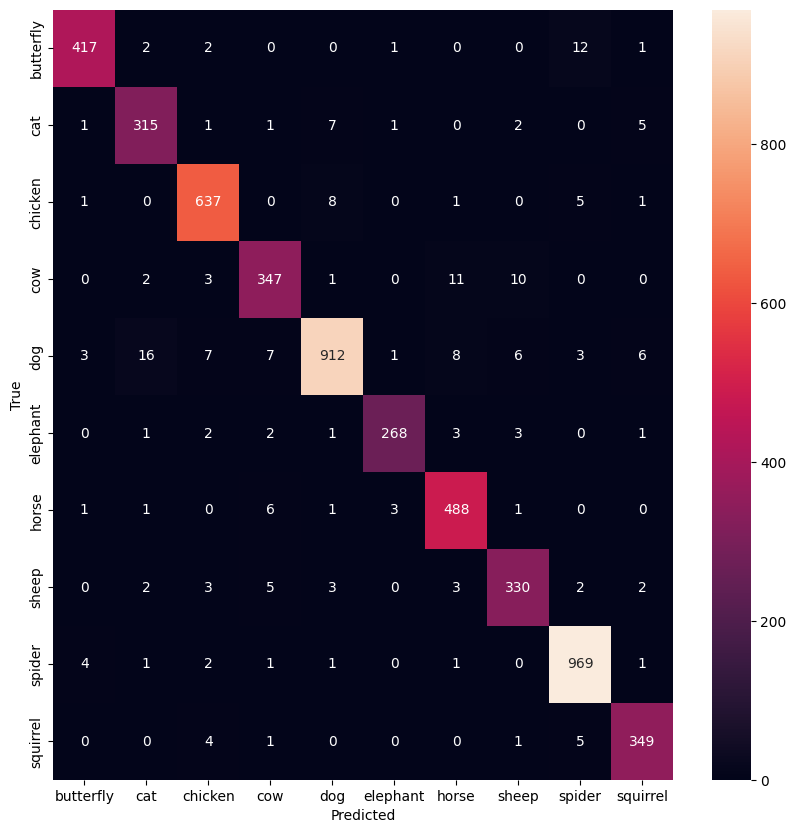

              precision    recall  f1-score   support

   butterfly       0.98      0.96      0.97       435
         cat       0.93      0.95      0.94       333
     chicken       0.96      0.98      0.97       653
         cow       0.94      0.93      0.93       374
         dog       0.98      0.94      0.96       969
    elephant       0.98      0.95      0.97       281
       horse       0.95      0.97      0.96       501
       sheep       0.93      0.94      0.94       350
      spider       0.97      0.99      0.98       980
    squirrel       0.95      0.97      0.96       360

    accuracy                           0.96      5236
   macro avg       0.96      0.96      0.96      5236
weighted avg       0.96      0.96      0.96      5236



In [27]:
def evaluate(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


    print(classification_report(all_labels, all_preds, target_names=class_names))


evaluate(transfer_model, val_loader)

In [28]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from google.colab import files


model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


class_names = [
    "butterfly", "cat", "chicken", "cow", "dog",
    "elephant", "horse", "sheep", "spider", "squirrel"
]


def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)


def predict_image(image_path):
    try:

        image = Image.open(image_path).convert("RGB")
        input_tensor = preprocess_image(image)

        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()

        predictions = {class_names[i]: float(probabilities[i]) for i in range(len(class_names))}
        return predictions
    except Exception as e:
        return {"error": str(e)}

def main():

    uploaded_files = files.upload()


    for image_name, image_content in uploaded_files.items():
        print(f"\nProcessing image: {image_name}")


        with open(image_name, "wb") as f:
            f.write(image_content)


        predictions = predict_image(image_name)

        if "error" in predictions:
            print(f"Error processing {image_name}: {predictions['error']}")
        else:
            print("Predictions with probabilities:")
            for class_name, prob in predictions.items():
                print(f"{class_name}: {prob:.4f}")


if __name__ == "__main__":
    main()

<ipython-input-28-ab0c475d5f09>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Saving horse png.png to horse png (1).png

Processing image: horse png (1).png
Predictions with probabilities:
butterfly: 0.0002
cat: 0.0003
chicken: 0.0003
cow: 0.0000
dog: 0.0020
elephant: 0.0000
horse: 0.9962
sheep: 0.0004
spider: 0.0006
squirrel: 0.0000
